In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from scipy.constants import pi, c as speed_of_light
import configparser
from tqdm.notebook import tqdm
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common



In [2]:
import sys
sys.path.insert(0,'..')

In [3]:
from utils.custom_configparser import CustomConfigParser
from environments import RIS_TFenv

In [4]:
# config = CustomConfigParser(interpolation=configparser.ExtendedInterpolation(),
#                             allow_no_value=True,
#                             inline_comment_prefixes=('#',))
# fin = open('setup_config.ini', 'r')
# config.read_file(fin)


config = CustomConfigParser.load_from_file(open('setup_config.ini', 'r'))
config.print()


[RIS]
phases             : [0, Pi]
element_dimensions : [0.3, 0.01]
element_gap        : [0.01, 0.01]
facing_direction   : perpendicular

[channel_modeling]
q                         : 0.285
l_h                       : 13.2
l_g                       : 13.2
l_siso                    : 0
shadow_fading_exists      : False
wall_attenuation          : 10
normalize_ge              : True
normalize_steering_vector : True
ignore_los                : False
tx_rx_mult_factor         : 0
units_scale               : power

[pathloss_indoor]
f0_los     : 24.2 * 10^9
n_los      : 3.19
b_los      : 0.06
sigma_los  : 8.29
f0_nlos    : 0
n_nlos     : 1.73
b_nlos     : 0
sigma_nlos : 3.02

[pathloss_outdoor]
f0_los     : 24.2 * 10^9
n_los      : 1.98
b_los      : 0
sigma_los  : 3.1
f0_nlos    : 0
n_nlos     : 3.19
b_nlos     : 0
sigma_nlos : 8.2

[setup]
environment_type   : outdoor
frequency          : 32 * 10^9
wall_exists        : true
number_of_ris      : 1
ris_elements       : [3,3]
ris_element_gr

In [5]:
env = RIS_TFenv(config, 1, transmit_SNR=1)
utils.validate_py_environment(env, episodes=1)
train_env = tf_py_environment.TFPyEnvironment(env)


In [6]:
num_eval_episodes = 100


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = train_env
time_step           = example_environment.reset()
random_policy.action(time_step)


def compute_avg_return(environment, policy, num_episodes=10, debug=False):

    total_return = 0.0
    
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


random_policy_average_return = compute_avg_return(train_env,
                                                  random_policy,
                                                  num_eval_episodes)



print(random_policy_average_return)

1.1189425e-18


----------------------------------------------------
----------------------------------------------------

# Train DQN

In [7]:
fc_layer_params = (100, 100)

num_actions = int(train_env.action_spec().maximum)-int(train_env.action_spec().minimum)+1



num_iterations              = 100*num_actions

initial_collect_steps       = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length    = 100000

batch_size                  = 32
learning_rate               = 1e-2
log_interval                = 20000000000000

eval_interval               = 40








def construct_Q_network(num_actions, fc_layer_params):
    def dense_layer(num_units):
          return tf.keras.layers.Dense(
              num_units,
              activation           = tf.keras.activations.relu,
              #kernel_regularizer   = tf.keras.regularizers.l1(10e-3),
              #activity_regularizer = tf.keras.regularizers.l2(.2),
              kernel_initializer   = tf.keras.initializers.VarianceScaling(scale=5.0, mode='fan_in',
                                                                           distribution='truncated_normal'),
          )


    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation         = None,
        kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
        bias_initializer   = tf.keras.initializers.Constant(-0.2),
        )

    return sequential.Sequential(dense_layers + [q_values_layer])




    
q_net        = construct_Q_network(num_actions, fc_layer_params)
target_q_net = construct_Q_network(num_actions, fc_layer_params)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    time_step_spec           = train_env.time_step_spec(),
    action_spec              = train_env.action_spec(),
    q_network                = q_net,
    target_q_network         = target_q_net,
    optimizer                = optimizer,
    train_step_counter       = train_step_counter,
    
    td_errors_loss_fn        = None, #common.element_wise_squared_loss,
    #emit_log_probability     = True,
    epsilon_greedy           = 0.2,
    #boltzmann_temperature    = 1.,
    gradient_clipping        = 100,
    n_step_update            = 1,
    #target_update_tau        = 0.01,
    #target_update_period     = 5,
    gamma                    = 0.999,
    #summarize_grads_and_vars = True,
)

agent.initialize()


eval_policy = agent.policy
collect_policy = agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)



def collect_step(environment, policy, buffer):
    time_step      = environment.current_time_step()
    action_step    = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj           = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [8]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)


# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
returns = [avg_return]
train_losses = []


print('Starting training')

try:
    for iter_cnt in tqdm(range(num_iterations)):
        collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience).loss
        step = agent.train_step_counter.numpy()

        train_losses.append(train_loss)
        
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)

except KeyboardInterrupt:
    print('Training aborted by user...')
    num_iterations = iter_cnt
    


Starting training


  0%|          | 0/51200 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 40: Average Return = 5.96239540346465e-19
step = 80: Average Return = 9.85180277959205e-19
step = 120: Average Return = 3.5087777357192855e-18
step = 160: Average Return = 1.1457420319151886e-18
step = 200: Average Return = 5.437607207442633e-19
step = 240: Average Return = 1.7511694809155864e-18
step = 280: Average Return = 1.0750575874161541e-18
step = 320: Average Return = 1.0597267253406729e-18
step = 360: Average Return = 3.2049478860788112e-18
step = 400: Average Return = 3.305512782640252e-18
step = 440: Average Return = 1.0144836681467788e-18
step = 480: Average Return = 6.269536870687481e-19
step = 520: Average Return = 1.0917426475519613e-18
step = 560: Average Return = 1.9019322465401138e-18
step = 600: Average Return = 6.652007091356101e

step = 5960: Average Return = 9.510096536497925e-19
step = 6000: Average Return = 1.0363193751618005e-18
step = 6040: Average Return = 5.73784430149006e-19
step = 6080: Average Return = 9.86383722352893e-19
step = 6120: Average Return = 9.532492451582798e-19
step = 6160: Average Return = 5.315785733692534e-19
step = 6200: Average Return = 4.989069037273637e-19
step = 6240: Average Return = 1.8678277966797056e-18
step = 6280: Average Return = 5.285042015263353e-19
step = 6320: Average Return = 2.7808829917055384e-18
step = 6360: Average Return = 6.508084902602234e-19
step = 6400: Average Return = 6.222782554514452e-19
step = 6440: Average Return = 2.019661554402336e-18
step = 6480: Average Return = 1.8557439287012247e-18
step = 6520: Average Return = 5.567863338501358e-19
step = 6560: Average Return = 9.907112211250407e-19
step = 6600: Average Return = 5.744810196223522e-19
step = 6640: Average Return = 1.014322574722484e-18
step = 6680: Average Return = 1.0760459648505784e-18
step = 67

Text(0.5, 0, 'Iterations')

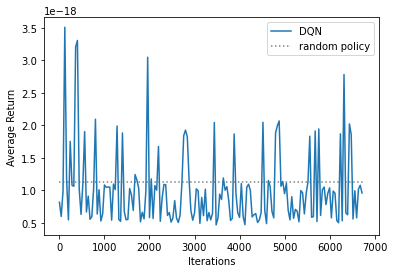

In [9]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns, label='DQN')
plt.hlines(random_policy_average_return, 0, num_iterations, colors='gray', linestyles='dotted', label='random policy')
plt.legend()
plt.ylabel('Average Return')
plt.xlabel('Iterations')

Text(0, 0.5, 'Train loss')

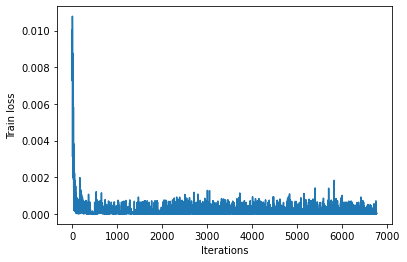

In [10]:
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Iterations')
plt.ylabel('Train loss')